In [0]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from plotnine import *
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics



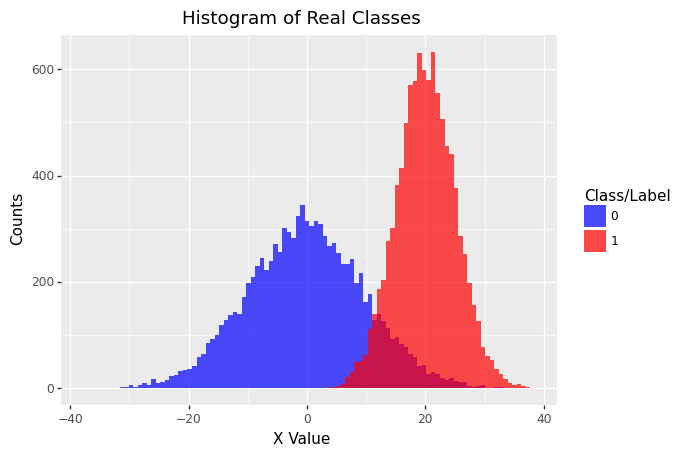

<ggplot: (8779122826076)>

In [53]:
np.random.seed(0)
m = 10000
x0, x1 = 0, 10
scale0, scale1 =  10, 5

samples_0 = x0 + np.random.normal(x0, scale0, m)
samples_1 = x1 + np.random.normal(x1, scale1, m)

x = np.concatenate((samples_1, samples_0))
y = np.concatenate((np.ones_like(samples_1), np.zeros_like(samples_0)))
df = DataFrame({'sample': x, 'label': y})

(ggplot(df, aes(x='sample', fill='factor(label)')) + 
 geom_histogram(position="identity", bins=100, alpha=.7) + 
 scale_fill_manual(values=["blue", "red"]) +
 labs(x="X Value", y="Counts", fill="Class/Label", title="Histogram of Real Classes"))



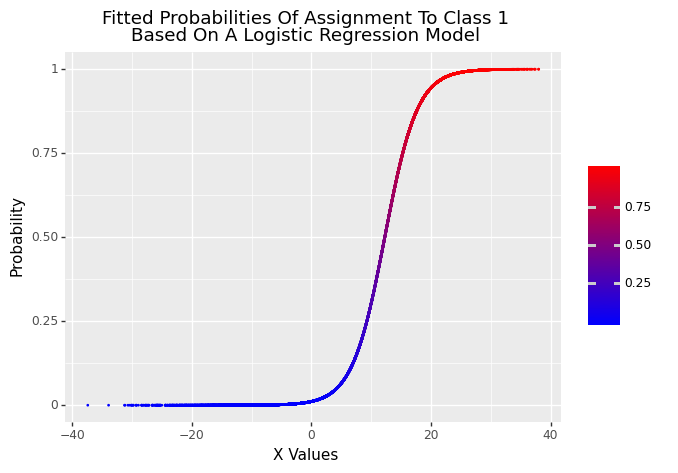

<ggplot: (8779122817151)>

In [54]:
# Fit a Logistic Regression model to the sampled data
model = LogisticRegression(solver='liblinear')
model.fit(x.reshape(-1,1), y)

# Test the model's performance on the given data and register both the calculated probabilities 
# (of a sample belonging to class 1) and which samples were classified correctly
df["pred_prob"] = model.predict_proba(x.reshape(-1,1))[:,1]

df["pred"] = model.predict(x.reshape(-1,1))
df["correct"] = df["pred"] == df["label"]

# Plotting the fitted probabilities of assignment to class 1. 
# Notice the uncertainty of the model the closer we get to p=0.5
(ggplot(df) + 
      geom_point(aes(x="sample", y="pred_prob", color="..y.."), size=.1) + 
      scale_color_gradient(low="blue", high="red") + 
      labs(x="X Values", y="Probability", color="", 
           title="Fitted Probabilities Of Assignment To Class 1\nBased On A Logistic Regression Model"))


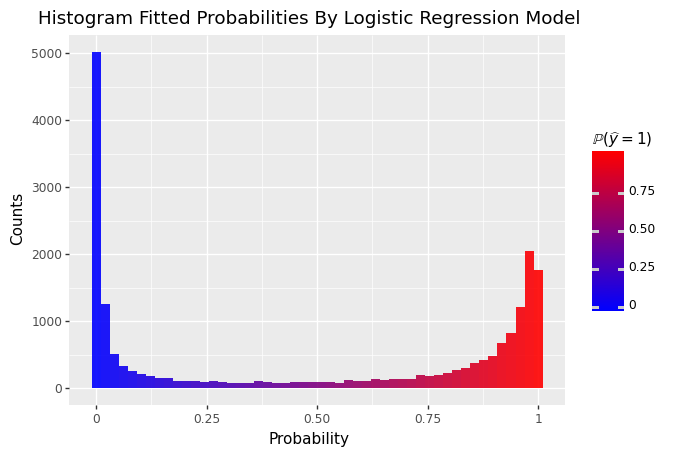

<ggplot: (-9223363257732037572)>

In [55]:
(ggplot(df, aes(x="pred_prob", fill="..x..")) + 
 geom_histogram(bins=50, alpha=.9) + 
 scale_fill_gradient(low="blue", high="red") +
 labs(x="Probability", y="Counts", fill=r"$\mathbb{P}\left(\widehat{y} = 1\right)$", 
      title="Histogram Fitted Probabilities By Logistic Regression Model"))



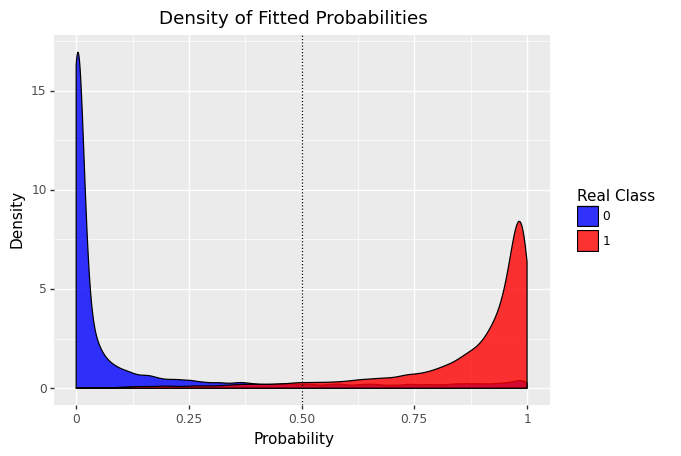

<ggplot: (8779122209207)>

In [56]:
(ggplot(df, aes(x="pred_prob")) + 
 geom_density(aes(fill="factor(label)"), alpha=.8) + 
 scale_fill_manual(values=["blue","red"]) + 
 geom_vline(xintercept=.5, linetype="dotted") + 
 labs(x="Probability", y="Density", fill="Real Class", 
      title="Density of Fitted Probabilities"))



Accuracy: 0.918
Precision: 0.900


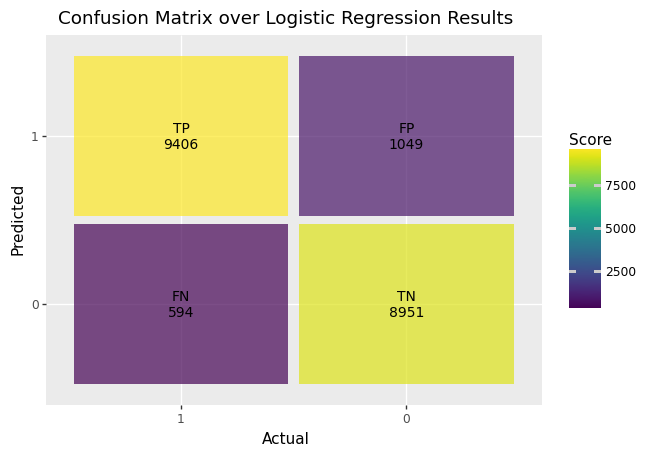

<ggplot: (-9223363257732812172)>

In [57]:
# Often we arrange classification results in what is called a Confusion Matrix. Given some categories c_1,...,c_n,
# a confusion matrix is an (n)x(n) matrix showing agreement of categories over samples in two scenarios.
# The simplest, and commonly used in supervised classification tasks, is a 2x2 matrix as follows below.
tn, fp, fn, tp = metrics.confusion_matrix(y, np.array(df["pred"])).ravel().astype(np.int64) # tn = true negative, fp = false positive ..
accuracy = metrics.accuracy_score(y, np.array(df["pred"]))
precision = metrics.precision_score(y, np.array(df["pred"]))

# Accuracy and precision are just two out of several measurements of performance of a classification algorithm
# over a 2x2 confusion matrix. Different applications and fields favor different measurements.
# Please read here for some others: https://en.wikipedia.org/wiki/Confusion_matrix

df = DataFrame({'Actual':['1', '1', '0', '0'], 
                'Predicted':['0', '1', '0', '1'], 
                'Score':[fn, tp, tn, fp],
                'Score_Text':["FN\n"+str(fn), "TP\n"+str(tp), "TN\n"+str(tn), "FP\n"+str(fp)]})

# keep the order of the DataFrame when displaying it
df['Actual'] = pd.Categorical(df['Actual'], categories=df['Actual'].unique())


print("Accuracy: %0.3f" % accuracy)
print("Precision: %0.3f" % precision)
# For more string.format options see here: https://pyformat.info/

(ggplot(df, aes('Actual', 'Predicted', fill='Score')) +
 geom_tile(aes(width=.95, height=.95), alpha=.7) +
 geom_text(aes(label='Score_Text'), size=10) + 
 labs(title="Confusion Matrix over Logistic Regression Results"))

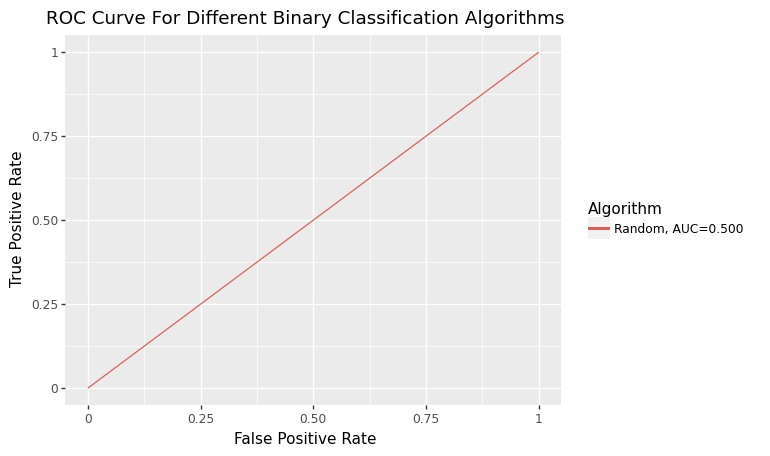

<ggplot: (8779121789125)>

In [58]:
# The last aspect we will discuss in this lab is the Receiver operating characteristic (ROC) curve.
# This is a graphical way to illustrate the diagnostic ability of a binary classifier. 

# Please, before you continue revisit https://en.wikipedia.org/wiki/Confusion_matrix and understand
# what do FPR and TPR represent.

# We will show you how to create the ROC curve for a random classifier (classifies points randomly)
# and the task of creating one for the Logistic Regression model (as well as another classification
# model is left as an assignment)

y_pred_prob = [0.5 for i in range(len(x))]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_prob)
auc = metrics.roc_auc_score(y, y_pred_prob)

p = (ggplot() + labs(x="False Positive Rate", y="True Positive Rate", color="Algorithm") + 
     ggtitle("ROC Curve For Different Binary Classification Algorithms"))
p += geom_line(aes(x='x', y='y', color = 'legend'), 
               data=DataFrame({'x':fpr ,'y':tpr, 'legend':["Random, AUC=%0.3f" % auc]*len(fpr)}), size= 0.5)
p

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Logistic.Regression.Lab.Output.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


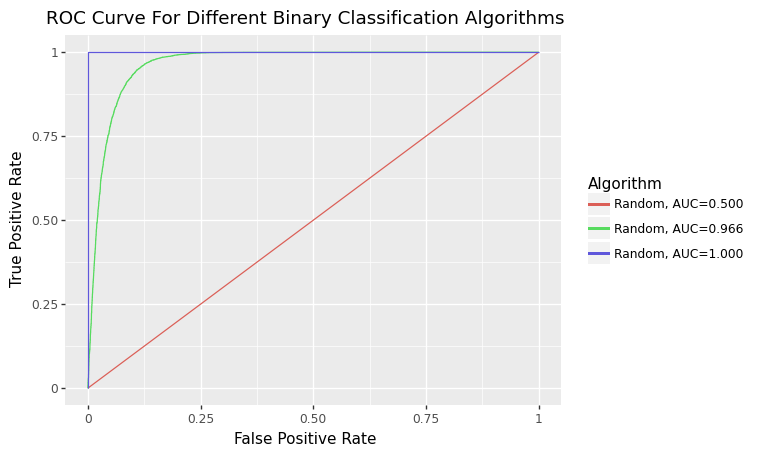

<ggplot: (8779121789125)>

In [59]:
def append_roc_logistic_regression(plot, x, y):
    """
    Append to a given plot the ROC curve of a logistic regression model. Add to curve's legend the calculated AUC.
    :param plot: The plot to append to
    :param x: Samples to fit for 
    :param y: Samples' real classes
    :return: Original plot with ROC curve appended to it
    """
    model = LogisticRegression(solver='liblinear')
    model.fit(x, y)

    y_pred = model.predict_proba(x)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y, y_pred)
    auc = metrics.roc_auc_score(y, y_pred)

    plot += (labs(x="False Positive Rate", y="True Positive Rate", color="Algorithm")) 

    plot += geom_line(aes(x='x', y='y', color = 'legend'), 
                  data=DataFrame({'x':fpr ,'y':tpr, 'legend':["Random, AUC=%0.3f" % auc]*len(fpr)}), size= 0.5)
    return plot

def append_roc_decision_stump(plot, x, y):
    """
    Append to a given plot the ROC curve of a decision stump model. Add to curve's legend the calculated AUC.
    Hint: Use sklearn.tree's DecisionTreeClassifier class.
    Hint: How could we think of a decision stump in terms of classification trees?
    :param plot: The plot to append to
    :param x: Samples to fit for 
    :param y: Samples' real classes
    :return: Original plot with ROC curve appended to it
    """
    model = DecisionTreeClassifier()
    model.fit(x, y)

    y_pred = model.predict_proba(x)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y, y_pred)
    auc = metrics.roc_auc_score(y, y_pred)

    plot += (labs(x="False Positive Rate", y="True Positive Rate", color="Algorithm")) 

    plot += geom_line(aes(x='x', y='y', color = 'legend'), 
                  data=DataFrame({'x':fpr ,'y':tpr, 'legend':["Random, AUC=%0.3f" % auc]*len(fpr)}), size= 0.5)
    return plot

p = append_roc_logistic_regression(p, x.reshape(-1,1), y)
p = append_roc_decision_stump(p, x.reshape(-1,1), y)

ggsave(p, "Logistic.Regression.Lab.Output.png")
p